In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

import pickle

In [2]:
tracks = pd.read_csv('tracks_enriched.csv')
playlists = pd.read_csv('playlists-collections.csv')

In [3]:
tracks.head(1)

,playlist_id,track_id,name,artists,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,time_signature
0,37i9dQZF1DX4jP4eebSWR9,7oQepKHmXDaPC3rgeLRvQu,Komet,"Udo Lindenberg, Apache 207",81,167356,0.55,0.5,-5.779,0.045,0.285,0.0,0.116,0.351,115.016,7,0,4


## Enrich tracks with category

- add the category with which the playlist was tagged (from which the song was collected) 

In [4]:
tracks['category_name'] = 0

In [5]:
for i, row in playlists.iterrows():
    tracks.loc[tracks['playlist_id'] == row['playlist_id'], 'category_name'] = row['category_name']

In [6]:
tracks.head(2)

,playlist_id,track_id,name,artists,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,time_signature,category_name
0,37i9dQZF1DX4jP4eebSWR9,7oQepKHmXDaPC3rgeLRvQu,Komet,"Udo Lindenberg, Apache 207",81,167356,0.550,0.500,-5.779,0.045,0.285,0.000000,0.1160,0.351,115.016,7,0,4,In the car
1,37i9dQZF1DX4jP4eebSWR9,7DyDjhZMEIK5Ied4juTCyc,Sie weiß (feat. Mero),"AYLIVA, MERO",79,151319,0.792,0.679,-5.516,0.041,0.517,0.000015,0.0962,0.204,119.932,9,0,4,In the car


## Apply PCA to look at data shape

In [34]:
X = tracks[['danceability', 'energy', 'loudness', 'speechiness','acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo']]

In [75]:
def apply_PCA(scaler, dim): 
    pca = PCA(dim) 
    X_prepped = scaler.fit_transform(X)
    X_ = pca.fit_transform(X_prepped)
    
    df = pd.DataFrame(X_, columns=[*map(str, range(1, dim+1))])
    df['category_name'] = tracks['category_name']
    
    return df

In [76]:
minmax_PCA = apply_PCA(MinMaxScaler(), 2)
sc_PCA = apply_PCA(StandardScaler(), 2)

### Plot tracks with selected categories from original playlist

In [79]:
subset_categories = ['Hip-Hop', 'Rock', 'R&B', 'Romance', 'Jazz', 'Reggae'] 
subset_minmax_PCA = minmax_PCA[minmax_PCA['category_name'].isin(subset_categories)]
subset_sc_PCA = sc_PCA[sc_PCA['category_name'].isin(subset_categories)]

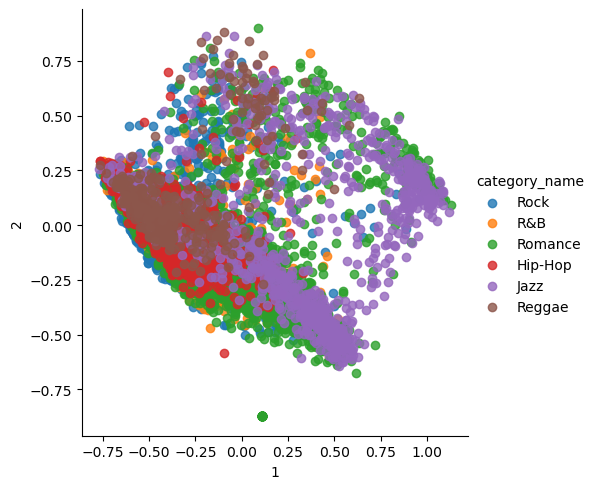

In [80]:
sns.lmplot(x='1', y='2', data=subset_minmax_PCA, hue='category_name', fit_reg=False)

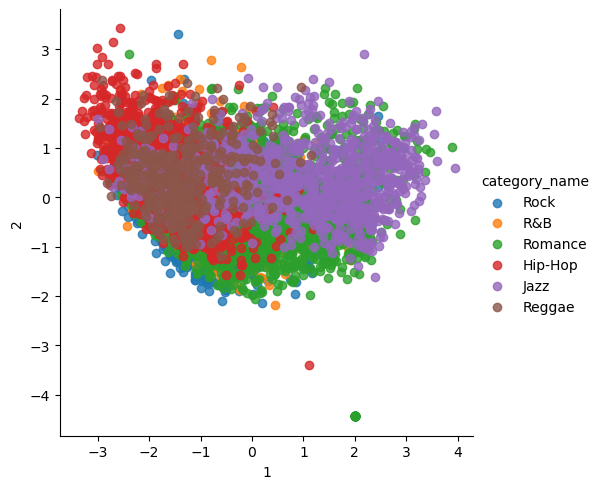

In [81]:
sns.lmplot(x='1', y='2', data=subset_sc_PCA, hue='category_name', fit_reg=False)

### Plot on 3 dimensions to get better insight

In [87]:
sc_3D_PCA = apply_PCA(StandardScaler(), 3)

In [95]:
subset_sc_3D_PCA = sc_3D_PCA[sc_3D_PCA['category_name'].isin(['Rock', 'Hip-Hop'])]

In [96]:
fig = px.scatter_3d(subset_sc_3D_PCA, x='1', y='2', z='3', color='category_name')
fig.show()

Observations:
- there seems to be some distinct clustering for category 
- but there are also areas where it overlaps a lot

### Apply KMeans Clustering

In [100]:
def cluster_search_KMeans(X, n_clusters=range(3, 25)):
    K = n_clusters
    inertia = []
    silhouette = []
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=13)
        kmeans.fit(X)
        pred = kmeans.predict(X)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X, pred))

    return inertia, silhouette

In [101]:
sc = StandardScaler()
sc.fit(X)

StandardScaler()

In [102]:
inertia, silhouette = cluster_search_KMeans(sc.transform(X))

## Plot inertia and silhouette for n_clusters

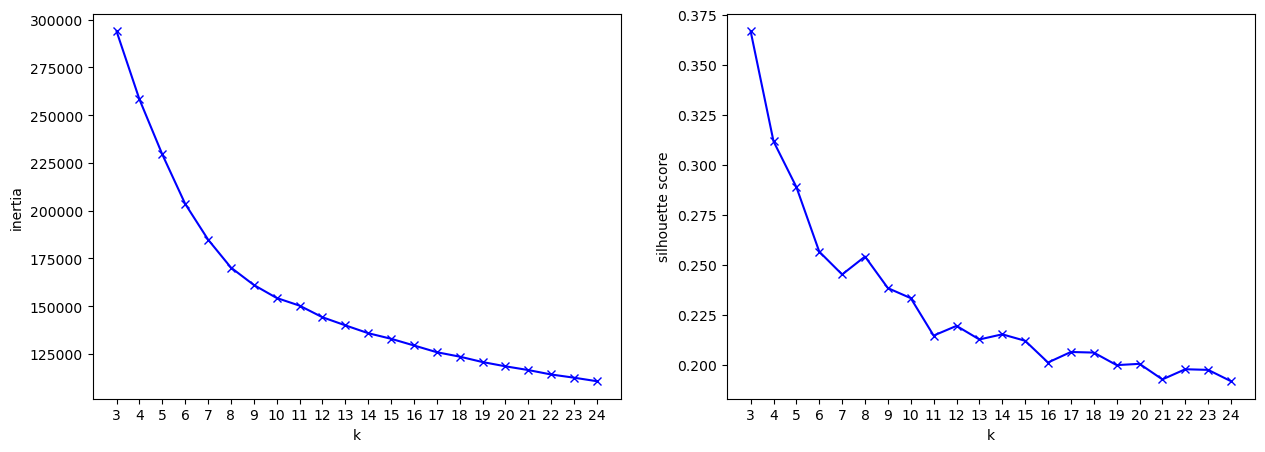

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
K = range(3, 25) 
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))

ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))

plt.show()

- difficult to understand what the best number for n_clusters would be here

## Apply Yellowbrick Elbow Visualizer 

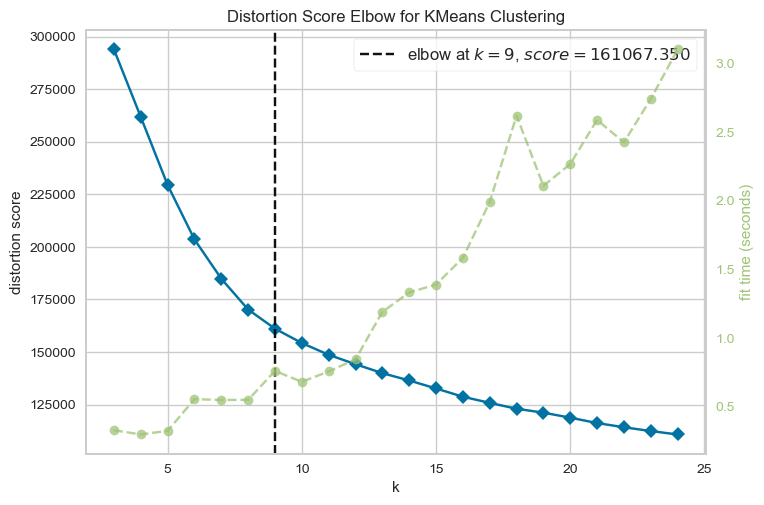

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [107]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,25))

visualizer.fit(sc.transform(X))       
visualizer.show()  

## Fit KMeans for 9 clusters and enrich tracks list with predicted cluster

In [108]:
X_scaled = sc.transform(X)
k = 9
kmeans = KMeans(n_clusters=k, random_state=13)
kmeans.fit(X_scaled)
pred = kmeans.predict(X_scaled)

In [112]:
tracks['cluster'] = pred

In [114]:
tracks['cluster'].unique()

array([7, 2, 5, 4, 1, 6, 8, 0, 3], dtype=int32)

### Save Scaler, Model and clustered tracks csv

In [115]:
tracks.to_csv('tracks_clustered.csv', index=None)

In [117]:
pickle.dump(kmeans, open('kmeans.pkl', 'wb'))

In [118]:
pickle.dump(sc, open('fitted_scaler.pkl', 'wb'))